# Question 1

In [303]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [304]:
#Fama french factors
ff_df = pd.read_csv('../data/ff_factors_and_mom.csv', sep=',')
ff_df['date'] = pd.to_datetime(ff_df['date'], format='%d/%m/%Y', dayfirst=True)
ff_df.set_index('date', inplace=True)

In [305]:
# industry portfolio
ind_df = pd.read_csv('../data/49_industry_portfolios.csv', sep=',')

ind_df['date'] = pd.to_datetime(ind_df['date'], format='%d/%m/%Y')
ind_df.set_index('date', inplace=True)

In [306]:
ind_ret = ind_df / 100.0

In [307]:
#Rolling 10y annualized (*12) mean returns
rolling_mean_10y = ff_df['mom'].rolling(window=120).mean() * 12

In [308]:
def calculate_stats(series, name="Series"):
    ann_mean = series.mean() * 12
    #ann_std = series.std() * np.sqrt(12)
    t_stat = series.mean() / (series.std() / np.sqrt(len(series)))
    return ann_mean, t_stat

In [309]:
mean_full, t_full = calculate_stats(ff_df['mom'], "Full History")

In [310]:
mean_full, t_full

(0.07475979381443301, 4.520011040876052)

In [311]:

last_date = ff_df.index[-1]
start_20y = last_date - pd.DateOffset(years=20)
mom_20y = ff_df[ff_df.index > start_20y]
mean_20y, t_20y = calculate_stats(mom_20y, "Last 20Y")

In [312]:
mean_20y

rf       0.013454
mktrf    0.094088
smb      0.003396
hml     -0.004013
mom      0.004178
dtype: float64

In [313]:
t_20y

rf       12.279393
mktrf     2.739705
smb       0.177951
hml      -0.163763
mom       0.122725
dtype: float64

In [314]:
start_10y = last_date - pd.DateOffset(years=10)
mom_10y = ff_df[ff_df.index > start_10y]
mean_10y, t_10y = calculate_stats(mom_10y, "Last 10Y")

In [315]:
mean_10y

rf       0.011574
mktrf    0.112116
smb     -0.013448
hml     -0.016334
mom      0.009660
dtype: float64

In [316]:
t_10y

rf       8.322089
mktrf    2.265468
smb     -0.450509
hml     -0.403593
mom      0.225216
dtype: float64

## Construct Industry Momentum strategy

for robustness check

In [317]:
rolling_11m_cumulative = (1 + ind_ret).rolling(11).apply(np.prod, raw=True) - 1
past_performance = rolling_11m_cumulative.shift(2)
past_performance.sample(n=5)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
1953-12-31,-0.132024,0.054466,NaN,-0.039716,0.122165,0.117376,0.065389,0.102418,-0.011752,-0.005659,...,0.107898,-0.052458,-0.106158,0.011758,0.000435,0.034959,-0.091504,0.185227,0.013024,0.010418
1982-12-31,-0.020434,0.333767,0.263018,0.444129,0.245843,0.287823,0.216269,0.260525,0.316834,0.388877,...,0.252202,0.052252,0.279007,0.542738,0.302639,0.171772,0.115467,0.104024,0.123132,0.085197
1973-03-30,0.040467,0.061495,0.152136,0.085158,0.003562,-0.180774,0.036758,-0.126215,0.146811,-0.202314,...,0.103363,-0.206565,-0.106296,-0.011140,0.069505,0.134626,-0.028504,-0.322105,0.050053,-0.285565
1999-10-29,0.121810,-0.013627,0.079661,0.120848,-0.150776,-0.026924,0.260379,0.291308,0.327002,0.077704,...,0.401348,0.142198,0.097533,0.344332,0.238929,0.164288,0.119542,-0.071505,0.480445,-0.166063
2001-06-29,-0.006816,0.099014,0.223599,-0.071241,1.045647,0.057363,-0.112550,0.037008,-0.033585,0.205430,...,-0.085751,0.179210,0.124646,0.006692,0.039732,0.151201,0.198563,0.145379,0.101938,-0.010299


In [318]:
ind_mom_returns = []
valid_dates = []

# Loop through dates where we have enough history
for date in ind_ret.index:
    if date not in past_performance.index:
        continue

    past_rets = past_performance.loc[date]
    curr_rets = ind_ret.loc[date]

    if past_rets.isna().all():
        continue

    # Rank industries
    sorted_inds = past_rets.sort_values()
    # Remove nulls
    sorted_inds = sorted_inds.dropna()

    if len(sorted_inds) < 10:
        continue  # Need at least 10 industries to do top 5 / bottom 5

    # Long Top 5, Short Bottom 5
    bottom_5 = sorted_inds.index[:5]
    top_5 = sorted_inds.index[-5:]

    # Strategy Return = Average(Winners) - Average(Losers)
    ret = curr_rets[top_5].mean() - curr_rets[bottom_5].mean()

    ind_mom_returns.append(ret)
    valid_dates.append(date)

In [319]:
ind_mom_series = pd.Series(ind_mom_returns, index=valid_dates)
ind_mom_series.sample(n=5)

1941-08-30    0.03108
2022-09-30    0.02672
1937-08-31    0.04944
1964-11-30    0.01362
2018-09-28   -0.00166
dtype: float64

In [320]:
ind_mom_rolling = ind_mom_series.rolling(window=120).mean() * 12
ind_mom_rolling.sample(n=5)

1985-06-28    0.089348
1970-08-31    0.184420
1974-07-31    0.211584
1996-07-31    0.060438
1970-11-30    0.176832
dtype: float64

In [321]:
correlation = ff_df['mom'].corr(ind_mom_series)
correlation

0.7456660589313867

## Visuals

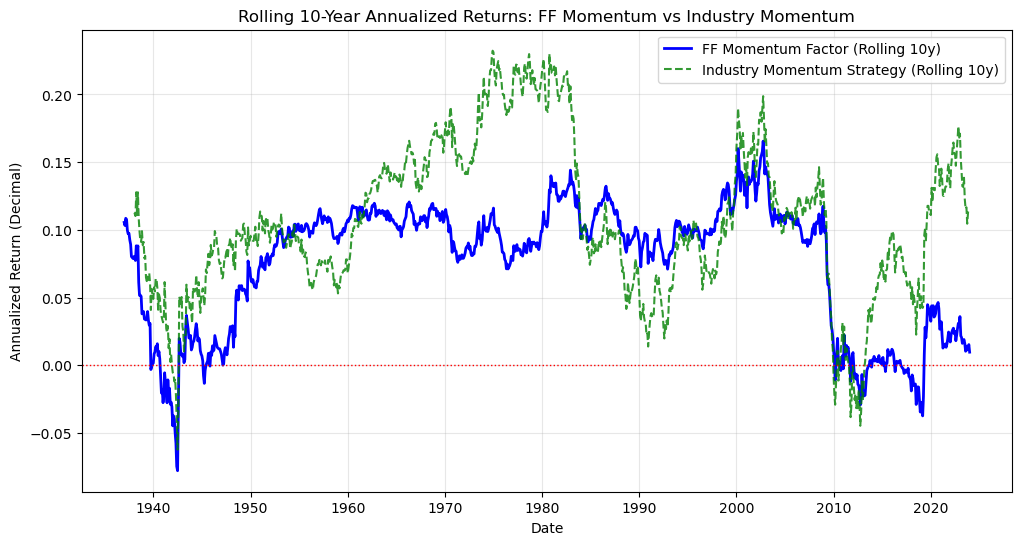

In [322]:
plt.figure(figsize=(12, 6))

# FF Momentum
plt.plot(rolling_mean_10y.index, rolling_mean_10y,
         label='FF Momentum Factor (Rolling 10y)', color='blue', linewidth=2)
#Industry momentum
plt.plot(ind_mom_rolling.index, ind_mom_rolling,
         label='Industry Momentum Strategy (Rolling 10y)', color='green', linestyle='--', alpha=0.8)

plt.axhline(0, color='red', linestyle=':', linewidth=1)

plt.title('Rolling 10-Year Annualized Returns: FF Momentum vs Industry Momentum')
plt.ylabel('Annualized Return (Decimal)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


This graph illustrates the rolling 10-year annualized returns of the Fama-French Momentum factor and an Industry Momentum strategy. It highlights a distinct structural break: while momentum consistently delivered positive premiums (often >5%) for most of the 20th century, returns for both strategies have collapsed to approximately zero over the last two decades, suggesting a potential regime change in market efficiency. There is clearly a post abd pre momentum crash

In [323]:
mom_series = ff_df['mom']
mean_mom = mom_series.mean()
std_mom = mom_series.std()
t_stat, p_value = stats.ttest_1samp(mom_series, 0)


annual_std = std_mom * np.sqrt(12)
sharpe_ratio = mean_full / annual_std

print("Full history stats")
print(f"Annualized Mean: {mean_full:.2%}")
print(f"Annualized Std Dev: {annual_std:.2%}")
print(f"T-statistic: {t_full:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}\n")

Full history stats
Annualized Mean: 7.48%
Annualized Std Dev: 16.29%
T-statistic: 4.5200
P-value: 6.8152e-06
Sharpe Ratio: 0.4589



In [324]:
# 4. 10y by 10y
ff_df['decade'] = (ff_df.index.year // 10) * 10
decade_stats = ff_df.groupby('decade')['mom'].agg(['mean', 'std', 'count'])
decade_stats['annual_mean'] = decade_stats['mean'] * 12
decade_stats['t_stat'] = (
    decade_stats['mean'] / (decade_stats['std'] / np.sqrt(decade_stats['count'])))

print(decade_stats[['annual_mean', 't_stat']])

# 5. Last 10 Years Performance (Rolling 120 months)
last_decade_mom = mom_series.iloc[-120:]
last_decade_mean = last_decade_mom.mean() * 12
last_decade_tstat, last_decade_p = stats.ttest_1samp(last_decade_mom, 0)
print('Last 10y stats')
print(f"Annualized Mean: {last_decade_mean:.2%}")
print(f"T-statistic: {last_decade_tstat:.4f}")
print(f"P-value: {last_decade_p:.4f}")

        annual_mean    t_stat
decade                       
1920       0.240600  4.559609
1930       0.001640  0.015788
1940       0.065930  2.215237
1950       0.107360  4.335235
1960       0.110930  3.742224
1970       0.098790  2.389921
1980       0.091900  2.348188
1990       0.136080  3.860548
2000       0.010850  0.144856
2010       0.032560  0.945502
2020      -0.007625 -0.096070
Last 10y stats
Annualized Mean: 0.97%
T-statistic: 0.2247
P-value: 0.8226


### 1. **Declining Performance Over Time**
- **Full history annualized mean**: 7.48% (t-stat: 4.52, highly significant)
- **Last 20 years**: 0.42% (t-stat: 0.12, not significant)
- **Last 10 years**: 0.97% (t-stat: 0.23, not significant)

The momentum premium has essentially disappeared in recent decades, with no statistical significance.

Recent decades show weaker momentum performance compared to earlier periods, suggesting a structural shift in markets.

The industry momentum strategy (correlation: **0.83** with FF momentum) shows similar patterns, confirming this isn't just a data artifact.

## Possible Explanations:
- Crowding: Momentum strategies are now widely known and implemented, reducing excess returns
- Market efficiency: Increased information flow and algorithmic trading may have arbitraged away the premium
- Regime change: Market structure changes post-2008 financial crisis

Without strong evidence of recovery, momentum returns over the next decade are most likely to remain approximately zero, continuing the recent trend rather than reverting to historical means.

# Question 2

## Correlation between the Return on Momentum and Value Portfolios

We first clean the data

In [325]:
df_factors = pd.read_csv("../data/ff_factors_and_mom.csv")

In [326]:
df_factors["date"] = pd.to_datetime(df_factors["date"], dayfirst=True)
df_factors=df_factors.sort_values("date")
df_factors = df_factors.set_index("date")
df_factors.head()

,rf,mktrf,smb,hml,mom
date,,,,,
1927-01-31,0.0025,-0.0006,-0.0037,0.0454,0.0036
1927-02-28,0.0026,0.0418,0.0004,0.0294,-0.0214
1927-03-31,0.0030,0.0013,-0.0165,-0.0261,0.0361
1927-04-30,0.0025,0.0046,0.0030,0.0081,0.0430
1927-05-31,0.0030,0.0544,0.0153,0.0473,0.0300


We extract the momentum and value columns from our dataframe for futher analysis

In [327]:
df_mom_hml = df_factors[["mom", "hml"]].dropna()
df_mom_hml.head()

,mom,hml
date,,
1927-01-31,0.0036,0.0454
1927-02-28,-0.0214,0.0294
1927-03-31,0.0361,-0.0261
1927-04-30,0.0430,0.0081
1927-05-31,0.0300,0.0473


In [328]:
momentum = df_mom_hml["mom"]
value = df_mom_hml["hml"]

The summary statistics of the momentum and value portfolios are shown below

In [329]:
print("Momentum portfolio (MOM) summary statistics:")
print(momentum.describe())

print("\nValue portfolio (HML) summary statistics:")
print(value.describe())

Momentum portfolio (MOM) summary statistics:
count    1164.000000
mean        0.006230
std         0.047024
min        -0.520500
25%        -0.009525
50%         0.008050
75%         0.029525
max         0.182000
Name: mom, dtype: float64

Value portfolio (HML) summary statistics:
count    1164.000000
mean        0.003483
std         0.035754
min        -0.138700
25%        -0.014025
50%         0.001300
75%         0.017525
max         0.356100
Name: hml, dtype: float64


We compute the correlation between momemtum and value portfolios by taking the sample with all available data we have. 

In [330]:
corr_full_sample = df_mom_hml["mom"].corr(df_mom_hml["hml"])

print("The correlation between MOM and HML portfolios, taken full samples, is ", 
      round(corr_full_sample,4))


The correlation between MOM and HML portfolios, taken full samples, is  -0.4057


The result shows that the correlaiton is negative. To show if this pattern persists in other samples, we limit the scope of data to the most recent 10 years and recompute the correlation

In [331]:
end_date_10y = df_mom_hml.index.max()
start_date_10y = end_date_10y - pd.DateOffset(years=10)
df_10y = df_mom_hml.loc[start_date_10y:end_date_10y]

corr_10y = df_10y["mom"].corr(df_10y["hml"])

print("The correlation between MOM and HML portfolios in the most recent 10 years is ", 
      round(corr_10y,4))

The correlation between MOM and HML portfolios in the most recent 10 years is  -0.3004


It turns out that the correlation between momentum and value portfolios is still negative. 

We then apply a 24-month rolling window to see if the negative correlation exists across all time. 

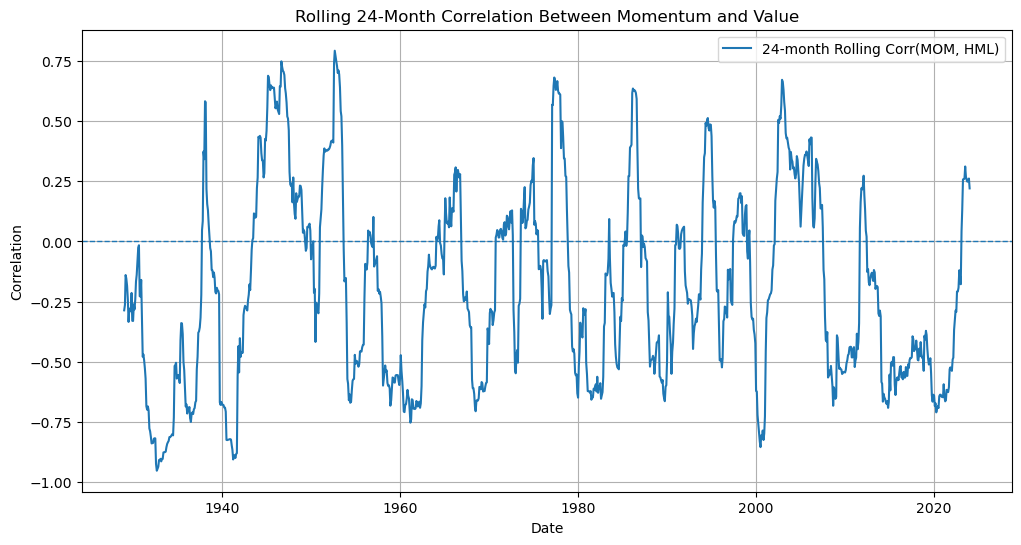

In [332]:
rolling_corr_24m = df_mom_hml["mom"].rolling(window=24).corr(df_mom_hml["hml"])

plt.figure(figsize=(12,6))
plt.plot(rolling_corr_24m, label="24-month Rolling Corr(MOM, HML)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Rolling 24-Month Correlation Between Momentum and Value")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)
plt.show()

In [333]:
print("Rolling correlation summary statistics:")
print(rolling_corr_24m.describe())

Rolling correlation summary statistics:
count    1141.000000
mean       -0.196593
std         0.404951
min        -0.952903
25%        -0.542226
50%        -0.243549
75%         0.094360
max         0.792801
dtype: float64


The plot shows the correlation between momentum and value portfolios for each 24-month rolling window. The rolling correlation fluctuates over time, occasionally becoming positive, but overall it tends to remain below zero. The summary statistics of our 24-month rolling windows show that the mean of correlation is negative (-0.1966). Momentum and values are then negatively correlated.

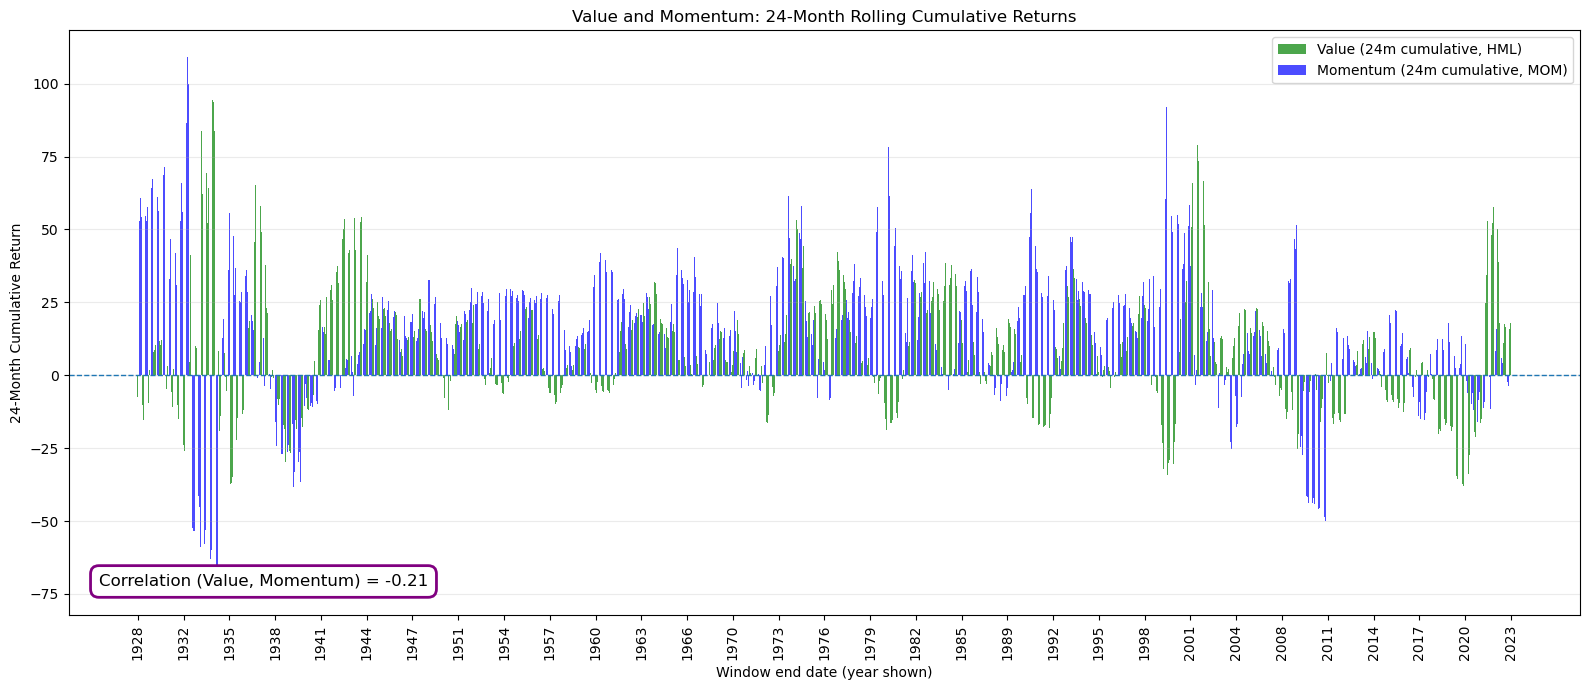

In [334]:
window = 24

def rolling_cumulative_return(r, window):
    # compute the cumulative return for each 24 month window.
    cumulative_return = (1.0 + r).rolling(window=window).apply(np.prod, raw=True) - 1.0
    return cumulative_return

roll_hml = rolling_cumulative_return(df_mom_hml["hml"], window)
roll_mom = rolling_cumulative_return(df_mom_hml["mom"], window)

# create a data frame for the rolling window data
roll = pd.DataFrame({"Value(HML)": roll_hml, "Momentum(MOM)": roll_mom}).dropna()

# the x-axis shows the end year of each window
years = roll.index.year.astype(int)

# compute the correlation
corr_24m_roll = roll["Value(HML)"].corr(roll["Momentum(MOM)"])

# plot
x = np.arange(len(roll))
bar_w = 0.42

plt.figure(figsize=(16, 7))
plt.bar(x - bar_w/2, roll["Value(HML)"] * 100, width=bar_w, color="green", 
        alpha=0.7, label="Value (24m cumulative, HML)")
plt.bar(x + bar_w/2, roll["Momentum(MOM)"] * 100, width=bar_w, color="blue",  
        alpha=0.7, label="Momentum (24m cumulative, MOM)")

plt.axhline(0, linestyle="--", linewidth=1)

plt.title("Value and Momentum: 24-Month Rolling Cumulative Returns")
plt.ylabel("24-Month Cumulative Return")
plt.xlabel("Window end date (year shown)")

# Make x-axis more readable: show every Nth year label
N = max(1, len(years) // 30)   # ~30 labels across
tick_idx = np.arange(0, len(years), N)
plt.xticks(tick_idx, years[tick_idx], rotation=90)

plt.legend()

# Correlation value box 
plt.text(
    0.02, 0.05,
    f"Correlation (Value, Momentum) = {corr_24m_roll:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="purple", linewidth=2)
)

plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

The figure above plots the cumulative return of 24-month rolling windows of value and momentum portfolios over time. The green bars represent the cumulative returns of the value portfolio over each 24-month window. The blue bars represent the cumulative returns of the momentum portfolio. Each bar shows the performance of the portfolio in a 2-year (24 months) period, and the x-axis shows the ending year of that period. 

This figure is designed to investigate whether the returns of momentum and value portfolios tend to move together or in opposite directions. The result shows that both portfolios experience periods with strong positive cumulative returns as well as negative periods. Momentum does not always bring positive returns, with unsatisfactory performance in years like 1933 and 2003, ane 2009. This is likely due to the over exposure of momentum strategy in high-return sectors, resulting a less diversification across industries and making it vulnerable in economic crisis or major regime shifts. However, we also notice that a negative performance of momentum often accompanies with a relatively better or even positive performance of value portfolios, and vice versa. The figure therefore suggest a possible reduction of risks by combining momentum with value portfolios.

We compute the correlations between momentum and value portfolios over the full sample, the past 10 years, a rolling window of 24 months. The full sample correlation is -0.4057. The correlation using only the most-recent 10-year period is -0.3004. The rolling windows again show a negative mean correlation of -0.1966. These results show that there is a persistent negative relationship between the returns of momentum and value portfolios. $\textbf{The correlation is on average negative.}$ In other words, when momentum tends to perform well, value tends to perform poorly, and vice versa.

This negative relationship between returns of momentum and value gives an important investment implication. Since one portfolio experiences significant loss in certain period when the other one is good, momentum and value provide diversification benefits when we hold them together. Such a combination is promising to help reduce portoflio volatility and benefits the overall returns. We will then discuss specifically on how should AQR design a combined VALUE + MOM  strategy in order to improve diversification and deliver stable performance for mutual fund investors.


## Momentum in Combination with Value

To test the effectiveness in generating returns of the momentum + value combination, we compare the following strategies:
1. Value-only
$\newline$
$\begin{align}
r^V_t = HML_t 
\end{align}$

2. Momentum-only
$\newline$
$\begin{align}
r^M_t = MOM_t 
\end{align}$

3. 50/50 Momentum & Value
$\newline$
$\begin{align}
r^{50/50}_t = 0.5HML_t +0.5MOM_t
\end{align}$

4. Volatility-scaled Momentum & Value
$\newline$
$\begin{align}
r^{scaled}_t = w_V(t) HML_t + w_M(t) MOM_t
\end{align}$

In the 50/50 Momentum & Value strategy, we allocate half of our investment into momentum portfolio and half into value portfolio. In the Volatility-scaled Momentum & Value strategy, we adjust the weights dynamically, allocating more weights to the factor with lower recent volatility, with $w_V(t) + w_M(t) = 1$


Below we code each strategy and store its output returns in a dataframe

In [335]:
df_strategy = pd.DataFrame(index=df_mom_hml.index)
# below we have thr Value only, Momentum only, and 50/50 strategies.
df_strategy["Value (HML)"] = df_mom_hml["hml"]
df_strategy["Momentum (MOM)"] = df_mom_hml["mom"]
df_strategy["50/50 Combo"]=0.5*df_strategy["Value (HML)"]+0.5*df_strategy["Momentum (MOM)"]

# we construct the volatility-adjusted strategies.
window = 24
volatility_value = df_strategy["Value (HML)"].rolling(window=window).std()
volatility_mom = df_strategy["Momentum (MOM)"].rolling(window=window).std()
weight_value = 1 / volatility_value
weight_mom = 1 / volatility_mom

weight_sum = weight_value + weight_mom
weight_value = (weight_value / weight_sum).shift(1)
weight_mom   = (weight_mom / weight_sum).shift(1)

# add the volatility-scaled strategy into the dataframe
df_strategy["Volatility-Scaled Combo"] = weight_value * df_strategy["Value (HML)"] + \
    weight_mom * df_strategy["Momentum (MOM)"]


In [336]:
def annualized_return(r):
    return r.mean() * 12

def annualized_volatility(r):
    return r.std() * np.sqrt(12)

def sharpe_ratio(r):
    return annualized_return(r) / annualized_volatility(r)

def max_drawdown(r):
    wealth = (1 + r).cumprod()
    peak = wealth.cummax()
    drawdown = (wealth - peak) / peak
    return drawdown.min()

We create a table to show the performance of each strategy

In [337]:
df_common = df_strategy.dropna() 
performance = pd.DataFrame(index=df_common.columns)
for col in df_common.columns:
    r = df_common[col].dropna()
    performance.loc[col, "Ann. Mean"] = annualized_return(r)
    performance.loc[col, "Ann. Vol"] = annualized_volatility(r)
    performance.loc[col, "Sharpe"] = sharpe_ratio(r)
    performance.loc[col, "Max Drawdown"] = max_drawdown(r)

performance = performance.astype(float)
performance = performance.round(4)

performance

,Ann. Mean,Ann. Vol,Sharpe,Max Drawdown
Value (HML),0.0434,0.1245,0.3486,-0.5841
Momentum (MOM),0.0720,0.1641,0.4387,-0.7724
50/50 Combo,0.0577,0.0804,0.7179,-0.4045
Volatility-Scaled Combo,0.0569,0.0777,0.7323,-0.3879


The result shows that 50/50 Value + Momentum strategy produces a substantially lower volatility (0.0804) compared to holding value (0.1245) or momentum alone (0.1641). Both the 50/50 and Volatility-scaled combination achieve a much higher Sharpe ratio (0.7179 and 0.7323), compared with value (0.3486) and momentum (0.4387). The combination also helps improve the downside risk. The maximum drawdown of the 50/50 and Volatility-scaled strategies (-0.4045 and -0.3879) is much smaller than the drawdowns of value (-0.5841) and momentum (-0.7724). The result suggests that the extreme drawdown of momentum strategy during unfavorable market condition can be improved by combining momentum with value factor.

We compute the cumulative returns of each strategy, starting from 1980-01-01, and plot the figure for better comparisons

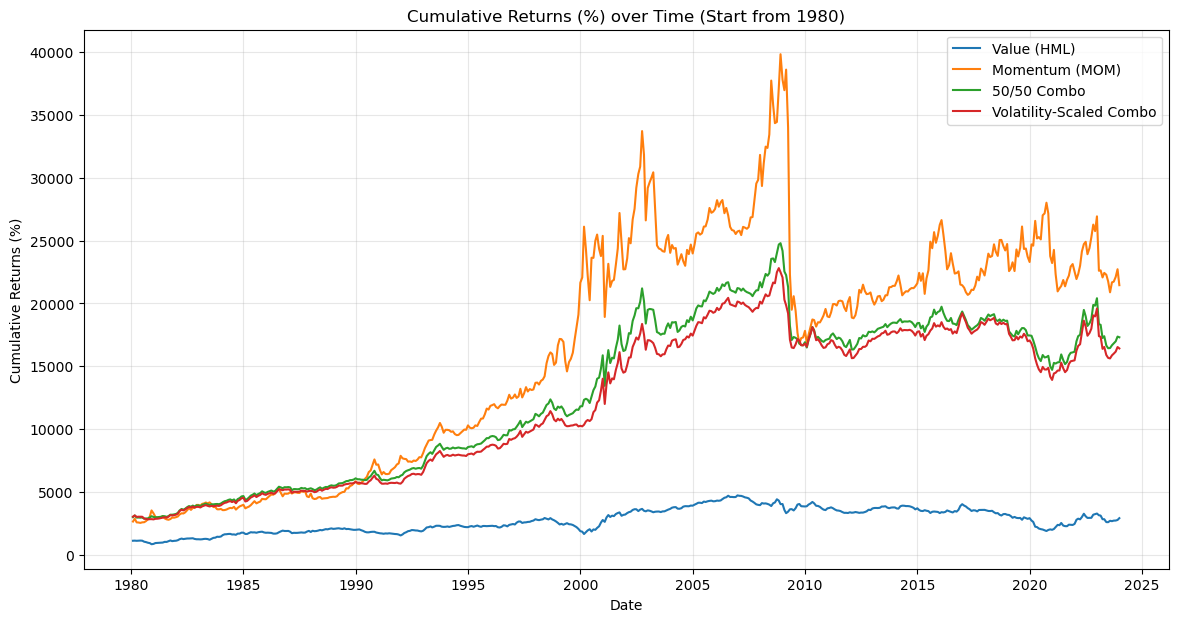

In [338]:
df_wealth = (1 + df_strategy.dropna()).cumprod()
df_cumret = (df_wealth - 1) * 100
plt.figure(figsize=(14, 7))

df_cumret_1980 = df_cumret.loc["1980-01-01":]

for col in df_cumret_1980.columns:
    plt.plot(df_cumret_1980.index, df_cumret_1980[col], label=col)

plt.title("Cumulative Returns (%) over Time (Start from 1980)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The cumulative return plot illustrates that both combined strategies generate a smoother and more stable performance path, especially during major market downturns, like the one happened around 2008-2009 for momentum-alone strategy.

Overall, the result suggests that the value factor can be used as an effective hedge tool against the momentum drawdown. Therefore, we recommend that AQR should position momentum as a diversifying return source that complements value investing. AQR can construct a portfolio can take half into investing in momentum and half in value (50/50), or it can dynamically adjust the weights of the two factors by their recent volatlities (Volatility-scaled). AQR could provide a blended "momentum+value" fund structure to improve risk-adjusted returns and reduce drawdowns and volatlities for investors.

Although the empirical findings support the combination of value and momentum, AQR must consider the real-world constraints. Momentum strategies typically involve higher turnover, which increases transaction costs and potential tax inefficiency in a mutual fund setting. More importantly, unlike hedge fund, many mutual funds are long-only, so the fund can only long the winners and cannot short the losers. AQR, in this case, may not be able to fully replicate the typical momentum strategy. Therefore, AQR should apply a portfolio construction technique that reduce trading frequency while still maintaining momentum exposure.

# Empirical Question 3